In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# custom packages
from ratsimulator import Agent, trajectory_generator, batch_trajectory_generator
from ratsimulator.Environment import OpenField
from ctimeit import ctimeit # for timing

import sys
sys.path.append("../../src") if "../../src" not in sys.path else None # avoid adding multiple relave paths to sys.path

from Models import SorscherRNN, UnitPathIntegratorTF

# Initialise Environment

In [3]:
# OpenField-Environment params
low = (0, 0)
high = (2.2, 2.2)

# Init Environment
env = OpenField(low=low,high=high)

# Initialise Agent / Data generator

In [4]:
# Training data (Agent) params
batch_size = 32
seq_len = 2
angle0 = None # random
p0 = None     # random

# As used by Sorscher
dt = 0.02
sigma = 5.76 * 2
b = 0.13 * 2 * np.pi
mu = 0

# Init training data
btg = batch_trajectory_generator(batch_size, env, seq_len, angle0, p0, dt=dt, sigma=sigma, b=b, mu=mu)

# Format data-generator

In [15]:
def to_one_hot(x):
    """OBS! if max(x,axis=-1) is not unique, then return result is not one-hot, but k-hot"""
    return np.where(x == np.max(x,axis=-1,keepdims=True),1,0)
    
def data_generator(btg):
    while True:
        pos, vel = next(btg)
        init_pos, y_true = pos[:,0], pos[:,1] # "next" pos is label
        vel = vel[:,1] # first velocity (idx 0) is always 0 (initial vel)
        yield (vel,init_pos), y_true 

# Initialise data generator
dg = data_generator(btg)

# Specify and instantiate Model

In [6]:
# Model params
Ng=2
Np=2
weight_decay=1e-4
activation=None#"relu"
lr=1e-3 # 1e-3 is default for Adam()

# model init
model = UnitPathIntegratorTF(Ng,Np,weight_decay,activation)

model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=lr),
    loss=tf.keras.losses.MeanAbsoluteError()
)

# Build (by specifying input_shape) and summarize model
input_shape = [(batch_size, 2), (batch_size, Np)] # velocity-input UNION initial-state
model.build(input_shape)
model.summary()

Model: "unit_path_integrator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
velocity_encoder (Dense)     multiple                  4         
_________________________________________________________________
init_position_encoder (Dense multiple                  4         
_________________________________________________________________
decoder (Dense)              multiple                  4         
_________________________________________________________________
activation (Activation)      multiple                  0         
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


# Train model

In [7]:
# train model
epochs = 15
steps_per_epoch = 200
model.fit(x=dg, epochs=epochs, steps_per_epoch=steps_per_epoch)

Epoch 1/15
200/200 [==============================] - 2s 8ms/step - loss: 1.4652
Epoch 2/15
200/200 [==============================] - 1s 7ms/step - loss: 0.9488
Epoch 3/15
200/200 [==============================] - 1s 6ms/step - loss: 0.4608
Epoch 4/15
200/200 [==============================] - 1s 6ms/step - loss: 0.3522
Epoch 5/15
200/200 [==============================] - 1s 6ms/step - loss: 0.2877
Epoch 6/15
200/200 [==============================] - 1s 7ms/step - loss: 0.2075
Epoch 7/15
200/200 [==============================] - 1s 7ms/step - loss: 0.1124
Epoch 8/15
200/200 [==============================] - 1s 6ms/step - loss: 0.0072
Epoch 9/15
200/200 [==============================] - 1s 6ms/step - loss: 0.0031
Epoch 10/15
200/200 [==============================] - 1s 6ms/step - loss: 0.0010
Epoch 11/15
200/200 [==============================] - 1s 6ms/step - loss: 9.4543e-04
Epoch 12/15
200/200 [==============================] - 1s 7ms/step - loss: 7.5068e-04
Epoch 13/15
200/2

In [8]:
# Ideal path integrator in Euclidean coordinates for a model: p = C@activation(A@v + B@p0) 
# should yield all weights as idendity weights ? 
model.weights

[<tf.Variable 'velocity_encoder/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.0796145 , -0.99566483],
        [ 0.6353176 , -0.35652557]], dtype=float32)>,
 <tf.Variable 'init_position_encoder/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.08186558, -0.9949532 ],
        [ 0.6376683 , -0.36296326]], dtype=float32)>,
 <tf.Variable 'decoder/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[-0.5464521 ,  1.4980081 ],
        [-0.95955974, -0.12341173]], dtype=float32)>]

# Interesting observations

In [9]:
# ACTUALLY! The weights doesn't have to be indentities, i.e.: < I >. It also works if 
# A = B, and C = A.inverse(). Thus, A & B are linear basis changes for A & B which is also a vector space?
# Thus their addition is well-defined. Afterwards, the inverse linear transform C takes us back into our 
# original coordinate system.

A,B,C = model.weights
A,B,C = A.numpy(),B.numpy(),C.numpy()

# Check if decoder weight is the inverse of the encoder weights
print("--- Are the three weight matricies approximately equal? ---\n")
print("A = ",A)
print("B = ",B)
print("C^-1 = ",np.linalg.inv(C))


C_inv = np.linalg.inv(C)
print("\nsum(abs(A-B)) = {}".format(np.sum(np.abs(A-B))))
print("sum(abs(A-C^-1)) = {}".format(np.sum(np.abs(A-C_inv))))
print("sum(abs(B-C^-1)) = {}".format(np.sum(np.abs(B-C_inv))))

--- Are the three weight matricies approximately equal? ---

A =  [[-0.0796145  -0.99566483]
 [ 0.6353176  -0.35652557]]
B =  [[-0.08186558 -0.9949532 ]
 [ 0.6376683  -0.36296326]]
C^-1 =  [[-0.0820084 -0.9954423]
 [ 0.6376376 -0.3631232]]

sum(abs(A-B)) = 0.011751078069210052
sum(abs(A-C^-1)) = 0.01153409481048584
sum(abs(B-C^-1)) = 0.0008225217461585999


In [81]:
ag = Agent(p0=np.ones((1,2))*(eps:=1e-5))
for i in range(100):
    ag.step(env.avoid_walls)

In [82]:
pi = [ag.positions[0]]
for i in range(len(ag.velocities)-1):
    inputs = [np.array([pi[-1]]), np.array([ag.velocities[i+1]])]
    pi.append(model(inputs).numpy()[0])
pi = np.array(pi)

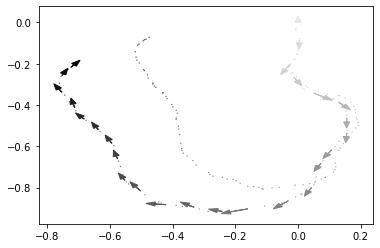

In [83]:
fig,ax=plt.subplots()
env.plot_board(ax)
ag.plot_trajectory(ax)
ag.plot_trajectory(ax,pi)